In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

## Loading CSVs into dict

In [2]:
# Reload vejledninger_html_2-11-2023.csv into vejledninger_html_dict as key,value pairs
import csv
import sys
csv.field_size_limit(sys.maxsize)

vejledninger_tekst_dict = {}
csv_file_path = 'data/vejledninger_tekst_8-11-2023.csv'
with open(csv_file_path, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    #Skip first row
    next(reader)

    for row in reader:
        key = row[0]
        value = row[1]
        vejledninger_tekst_dict[key] = value

In [3]:
print(f'A total of {len(vejledninger_tekst_dict)} vejledninger were loaded into vejledninger_html_dict.')

A total of 431 vejledninger were loaded into vejledninger_html_dict.


In [39]:
vejledninger_tekst_dict['Vejledning om ret til dagpenge efter barselsloven ved pasning af alvorligt syge børn'][0:3000]

'Vejledning om ret til dagpenge efter barselsloven ved pasning af alvorligt syge børn\nIndhold\n1.Indledning\n2.Personkreds\n2.1.Forældre/adoptivforældre\n3.Betingelser for ret til dagpenge ved pasning af alvorligt syge børn\n3.1.Alvorligt syge børn under 18 år\n3.2.Barnets sygdom skønnes at medføre ophold på hospital i mindst 12 dage\n3.2.1.Behandling eller pleje i hjemmet\n3.2.2.Lempeligere regel for enlige forsørgere\n3.3.Dokumentation - Lægeattestation\n3.4.Beskæftigelseskrav\n4.Administration\n4.1.Udbetaling Danmark\n4.2.Ansøgning om dagpenge\n4.2.1.Lønmodtagere og lediges ansøgning om dagpenge\n4.2.2.Selvstændigt erhvervsdrivendes ansøgning om dagpenge\n4.2.3.Frist for ansøgning\n4.2.3.1.Dispensation for overskridelse af fristen for lønmodtagere og ledige\n4.2.3.2.Dispensation for overskridelse af fristen for selvstændigt erhvervsdrivende\n4.2.4.Arbejdsgivers ret til refusion/frist for ansøgning og dispensation fra fristen\n5.Udbetaling/Beregning af dagpenge\n5.1.Almindelige beti

### Load into Llamaindex documents
Esentially just dicts with text and metadata

In [110]:
from llama_index import Document
documents_vejledninger = [Document(text=content, metadata={"file_name": name}) for name, content in vejledninger_tekst_dict.items()]
len(documents_vejledninger)

431

In [111]:
documents_vejledninger[0].metadata

{'file_name': 'Vejledning om beskæftigelseskravet for ret til barselsdagpenge'}

In [112]:
documents_vejledninger[0].text[0:500]

'Vejledning om beskæftigelseskravet for ret til barselsdagpenge\n\n1.Indledning\nI denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).\n\nI bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.\n\nDenne vejledning erstatter vejledning nr. 10066 af 29. december 2020 '

## Chunking text
First parsing the data into nodes (llamaindex way of structuring data, including the relation to other nodes, embedding info etc.)

In [53]:
from llama_index.node_parser import SentenceSplitter
from transformers import AutoTokenizer

#Setting max length and defining tokenizer as intended embedding model (e5)
node_parser = SentenceSplitter(chunk_size=512, 
                               chunk_overlap=0, 
                               #paragraph_separator="\n\n", 
                               tokenizer=AutoTokenizer.from_pretrained('intfloat/e5-base-v2').tokenize
                               )


nodes_vejledninger = node_parser.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

Parsing nodes:   0%|          | 0/431 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (16295 > 512). Running this sequence through the model will result in indexing errors


In [54]:
nodes_vejledninger[9].text

'2\nTimer, som lønmodtageren har arbejdet som selvstændig erhvervsdrivende i 4 måneders perioden kan efter omstændighederne medregnes ved opgørelsen af kravet om 160 timers beskæftigelse. Det kræver, at lønmodtageren er overgået fra selvstændig erhvervsvirksomhed til lønmodtagerbeskæftigelse i løbet af 4 måneders perioden, og lønmodtager med virksomheden har opfyldt beskæftigelseskravet efter lovens § 28.\n\nDet fremgår af § 3, stk. 3, i bekendtgørelsen, at antallet af timer, der kan medregnes, som udgangspunkt er 18 ½ time pr. uge. Dog kan medregnes yderligere timer, såfremt timetallet i virksomheden kan dokumenteres af lønmodtageren.\n\nEksempel: Borger opfylder ikke beskæftigelseskravet med de indberettede timer i indkomstregistret. Borger kan dokumentere at have arbejdet som selvstændig i 22 timer ugentligt. Derfor medregnes 22 timer ugentligt i opgørelsen af beskæftigelseskravet som lønmodtager.\n\n2.1.2.3.Sygedagpenge og dagpenge efter barselsloven - § 27, stk. 2, nr.'

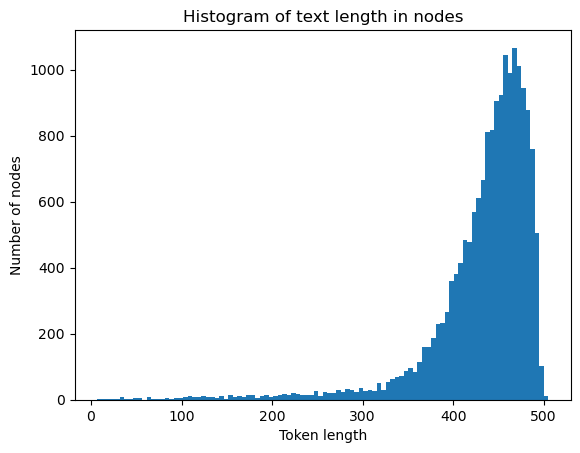

In [56]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
token_counts = []
for text in [node.text for node in nodes_vejledninger]:
    token_counts.append(len(tokenizer.tokenize(text)))

# Efficient batch processing to tokenize all texts
# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

#Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt
import numpy as np
text_len = token_counts
plt.hist(text_len, bins=100)
plt.title('Histogram of text length in nodes')
plt.xlabel('Token length')
plt.ylabel('Number of chunks')
plt.show()

In [58]:
#Print first 5 examples of texts under 100 tokens
for i in range(5):
    print(f'Example {i+1} of texts under 100 tokens:')
    print([node.text for node in nodes_vejledninger if len(tokenizer.tokenize(node.text)) < 100][i])
    print('\n')

Example 1 of texts under 100 tokens:
At-meddelelse 2.01.2 om gaffeltruckførercertifikat ophæves den 31. december 2017.

Arbejdstilsynet, den 22. november 2017


Example 2 of texts under 100 tokens:
Arbejdstilsynet, den 1. december  

 2001
Jens Jensen

Læs også Arbejdstilsynets vejledninger om:
(1)  

 	  

 Asbest
(1)  

 	  

 Sandblæsning
(1)  

 	  

 Bly
(2)  

 	  

 Højtryksrenseanlæg


Example 3 of texts under 100 tokens:
:
Branchefællesskaberne for arbejdsmiljøs vejledninger kan findes på www.bfa-web.dk

At-vejledning  B. 4.11 - November 2009 - Opstilling og opstillingskontrol af trykbærende udstyr og enheder, bortfalder.

Arbejdstilsynet, den 13. september 2019


Example 4 of texts under 100 tokens:
Læs også branchearbejdsmiljørådenes vejledninger mv.:
Branchearbejdsmiljørådenes vejledninger kan findes på www.bar-web.dk
Arbejdstilsynet, den 30. september 2016


Example 5 of texts under 100 tokens:
Branchearbejdsmiljørådenes vejledninger kan findes på www.bar-web.dk

Arbejdsti

**Short texts, what's happening?**

I inspected a few samples of the <100 token texts, and they all seem simply to be the end of documents, where this part likely could not fit into the context window of the previous chunk.

2 examples below,

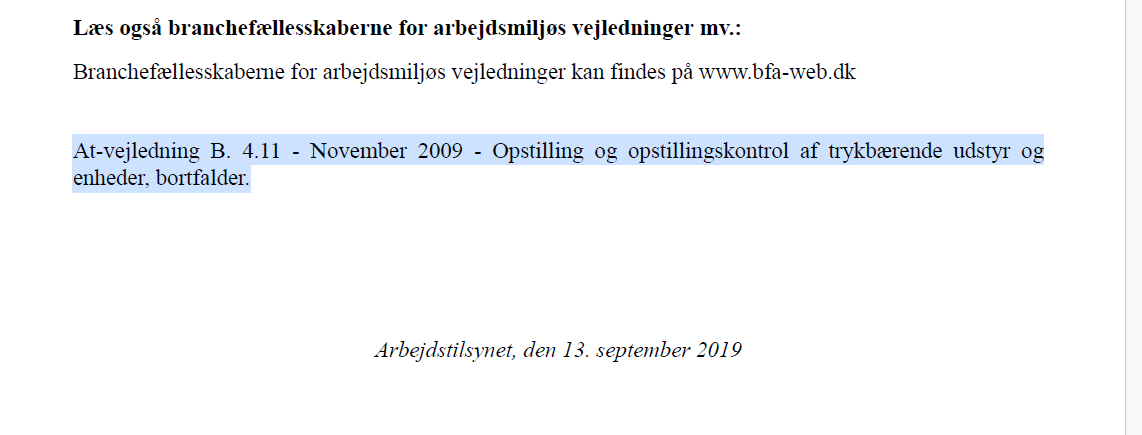


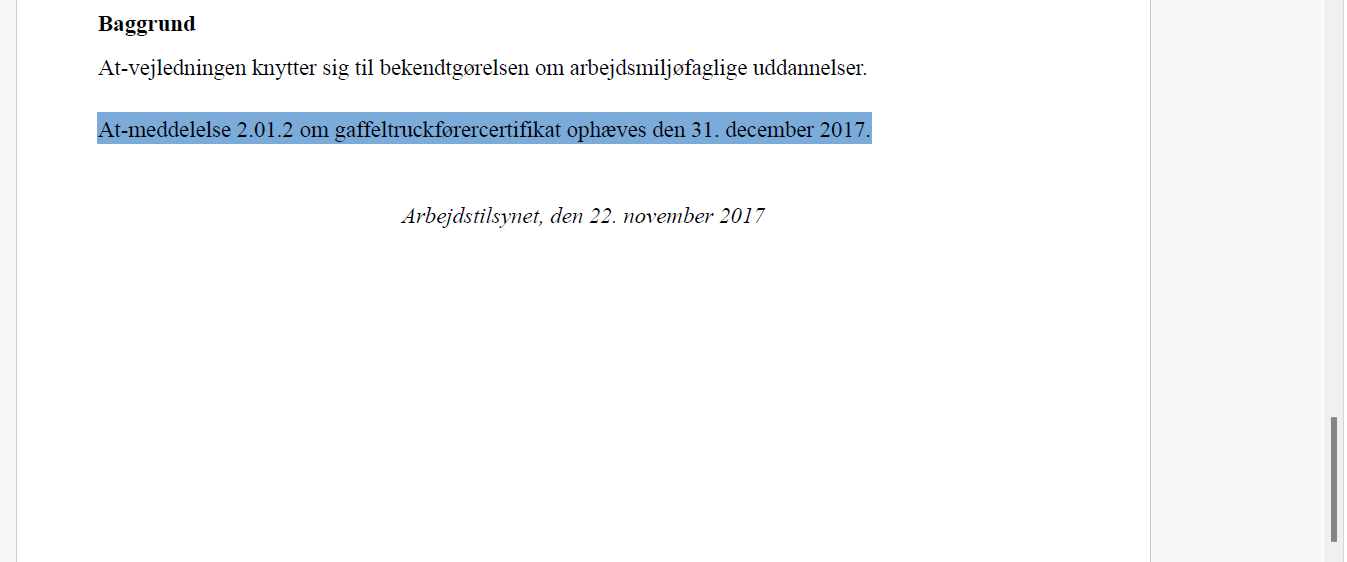

### Discarding short chunks
Discard any chunks less than 150 tokens long

In [63]:
nodes_vejledninger_filtered = [node for node in nodes_vejledninger if len(tokenizer.tokenize(node.text)) > 150]

In [65]:
nodes_vejledninger_filtered[0].text

'Vejledning om beskæftigelseskravet for ret til barselsdagpenge\n\n1.Indledning\nI denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).\n\nI bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.\n\nDenne vejledning erstatter vejledning nr. 10066 af 29. december 2020 om beskæftigelseskravet for ret til barselsdagpenge.\n\nEn lønmodtager har ret til barselsdagpenge, hvis pågældende opfylder ét af de fem krav om tilknytning til arbejdsmarkedet, der er nævnt i lovens § 27, stk. 1.\n\nKravet om aktuel beskæftigelse dagen før fraværet eller på første fraværsdag samt beskæftigelse i mindst 160 timer indberettet i indkomstregistret inden for de seneste 4 afsluttede kalendermåneder forud for fraværsperioden, jf. lovens § 27, stk. 1, nr. 1, er beskrevet i pkt

In [67]:
print(f'We now have {len(nodes_vejledninger_filtered)} chunks of text to generate questions from')

We now have 17284 chunks of text to generate questions from


## Generate Q for retrieval performance evaluation

**Write the Question gen prompt template**

In [68]:
from llama_index.prompts import PromptTemplate

# Define your custom prompt template in Danish
qa_sagsbehandler_tmlp = (
""" Nedenfor er et uddrag (kontekst) fra en længere tekst:
---------------------
{context_str}
---------------------
Givet ovenstående uddrag (kontekst) og ingen forudgående viden, er din opgave at generere spørgsmål til teksten.
Du er en erfaren sagsbehandler, og din opgave er at stille præcis {num_questions_per_chunk} spørgsmål til teksten.
Spørgsmålene skal være af forskellig karakter og dække teksten bredt, men stilles i et sprog som en borger uden juridisk ekspertise kan forstå.
Svaret til spørgsmålet, skal kunne findes i ovenstående uddrag (kontekst).
"""
)

qa_sagsbehandler_tmlp = PromptTemplate(qa_sagsbehandler_tmlp)

**Generate the questions**

In [69]:
from llama_index.finetuning import generate_qa_embedding_pairs
from llama_index.llms import OpenAI

# define LLM
llm_oai = OpenAI(temperature=0.0, model="gpt-3.5-turbo")

qa_dataset = generate_qa_embedding_pairs(qa_generate_prompt_tmpl=qa_sagsbehandler_tmlp,
                                            llm=llm_oai,
                                            nodes=nodes_vejledninger_filtered[0:300], 
                                            num_questions_per_chunk=2)

100%|██████████| 300/300 [14:22<00:00,  2.88s/it]


**Example of generated questions**

In [95]:
for query_id, query in qa_dataset.queries.items():
    node_id = qa_dataset.relevant_docs[query_id][0]
    text = qa_dataset.corpus[node_id]
    print(f'Spørgsmål:\n {query} \n')
    print(f'Chunk:\n {text} \n')
    break

Spørgsmål:
 Hvad er de fem krav om tilknytning til arbejdsmarkedet, som en lønmodtager skal opfylde for at have ret til barselsdagpenge? 

Chunk:
 Vejledning om beskæftigelseskravet for ret til barselsdagpenge

1.Indledning
I denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).

I bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.

Denne vejledning erstatter vejledning nr. 10066 af 29. december 2020 om beskæftigelseskravet for ret til barselsdagpenge.

En lønmodtager har ret til barselsdagpenge, hvis pågældende opfylder ét af de fem krav om tilknytning til arbejdsmarkedet, der er nævnt i lovens § 27, stk. 1.

Kravet om aktuel beskæftigelse dagen før fraværet eller på første fraværsdag samt beskæftigelse i mindst 160 timer indberettet i indkomstre

**Save / Load Q&A dataset**

In [70]:
#Save qa_dataset as json
qa_dataset.save_json("data/qa_dataset_21-11-23_300_samples.json")

In [ ]:
from llama_index.finetuning import EmbeddingQAFinetuneDataset
# Load the datasets from saved json files
#qa_dataset = EmbeddingQAFinetuneDataset.from_json("data/qa_dataset_21-11-23_300_samples.json")

## Set up the retriever
Vector db, embedding etc. for evaluation of retrieval

In [71]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model_hf = HuggingFaceEmbedding(
    model_name='intfloat/multilingual-e5-small',
    normalize=True,
    #Instruction to prepend query
    query_instruction='query:',
    #Instruction to prepend text
    text_instruction='passage:'
    
    #Or loading default values via
    #embed_model="local:intfloat/multilingual-e5-small"
)

In [72]:
from llama_index import ServiceContext

service_context_e5 = ServiceContext.from_defaults(embed_model= embed_model_hf)

In [73]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index import ServiceContext

embed_model_oai= OpenAIEmbedding(
    mode="text_search",  # default, alternatively set to "similarity"
    model="text-embedding-ada-002"  # default
)

In [74]:
service_context_ada = ServiceContext.from_defaults(embed_model= embed_model_oai)

In [75]:
from llama_index import VectorStoreIndex

vector_index_e5 = VectorStoreIndex(nodes_vejledninger_filtered[0:300], service_context=service_context_e5, show_progress=True)

Generating embeddings:   0%|          | 0/300 [00:00<?, ?it/s]

In [79]:
vector_index_ada = VectorStoreIndex(nodes_vejledninger_filtered[0:300], service_context=service_context_ada, show_progress=True)

Generating embeddings:   0%|          | 0/300 [00:00<?, ?it/s]

**Simple retriever test**

In [76]:
nodes_vejledninger_filtered[150].text

'Kurser – tillæring af nye kompetencer\n\nAfsnit B: Hjælpemidler\n\n7.Lovhjemmel\nArbejdsskadesikringslovens § 15 har følgende ordlyd:\n\n§ 15.Under sagens behandling kan udgifter til sygebehandling eller optræning betales, hvis det er nødvendigt for at opnå bedst mulig helbredelse, når udgifterne ikke kan afholdes efter sundhedsloven eller som led i behandlingen på offentligt sygehus.Optræningen skal foretages som efterbehandling under lægelig kontrol i umiddelbar tilknytning til sygebehandlingen.\nStk. 2.Under sagens behandling kan udgifter til anskaffelse af proteser, briller og lignende hjælpemidler samt kørestole betales, når det er nødvendigt for at sikre sygebehandlingens eller genoptræningens resultater, for at formindske arbejdsskadens følger eller for nøjere at kunne bestemme omfanget af erhvervsevnetabet og graden af varigt mén.\nStk. 3.Erstatning for fremtidige udgifter til helbredelse, optræning og hjælpemidler som følge af arbejdsskaden fastsættes til et engangsbeløb.Ved 

In [96]:
from llama_index.response.notebook_utils import display_source_node

retriever_e5 = vector_index_e5.as_retriever(similarity_top_k=3)
retrieved_nodes = retriever_e5.retrieve("Kan udgfter til køb af proteser eller kørestol dækkes som en del af genoptræningen?")

for node in retrieved_nodes:
    display_source_node(node, source_length=1000)

**Node ID:** 3c58f4fc-d0c4-4448-ae21-2e76a63ab842<br>**Similarity:** 0.925248919214829<br>**Text:** Det er kun tilskadekomnes egentlige udgifter, der kan dækkes, det vil sige den del af regningen, som ikke betales af det offentlige og eventuelle private sygeforsikringer, for eksempel Sygeforsikringen ”danmark ”.

Fysioterapi, biomekanisk bevægelsesterapi og kiropraktorbehandling
Udgifter til fysioterapi og kiropraktorbehandling kan dækkes, når der er tidsmæssig sammenhæng mellem arbejdsskaden og smerternes opståen og behandlingerne udføres af en autoriseret fysioterapeut eller kiropraktor. Behandlingerne skal efter en konkret vurdering af skadens art og omfang dækkes, når behandlingen er nødvendig for at opnå den bedst mulige optræning eller helbredelse af skadens følger.

Det er altid en konkret vurdering, i hvor lang tid og i hvilket omfang behandlingen er nødvendig for at mindske arbejdsskadens følger mest muligt. Normalt dækkes op til 20-30 behandlinger i de første 12 måneder efter skaden. Hvis tilskadekomne på grund af arbejdsskaden gennemgår en operation, vil vedkommende ige...<br>

**Node ID:** 781390a6-32f2-495a-ab7a-61e8b9aeabc4<br>**Similarity:** 0.9251693486944544<br>**Text:** 2, kan anskaffelsen af proteser, briller og lignende hjælpemidler samt kørestole betales under sagens behandling:

–hvis anskaffelsen er nødvendig for at sikre sygebehandlingens eller genoptræningens resultater, eller
–for at formindske arbejdsskadens følger, eller
–for nøjere at kunne bestemme omfanget af erhvervsevnetabet og/eller graden af det varige mén

Det er således en betingelse, at hjælpemidlet er anskaffet som følge af en skade, der er anerkendt eller vil kunne anerkendes som en arbejdsskade.

Hjælpemidlet skal være anskaffet for at erstatte tabet eller bedre funktionen af en legemsdel, der er beskadiget ved arbejdsskaden, og skal som udgangspunkt være individuelt fremstillet eller tilpasset.

7.1.1.Forholdet til anden lovgivning
I modsætning til § 15, stk. 1, er bestemmelsen i stk. 2 primær i forhold til anden lovgivning. Hvis der tilkendes erstatning for fremtidige udgifter til hjælpemidler efter § 15, stk. 3, vil denne erstatning ligeledes være primær i forhold til erst...<br>

**Node ID:** ef7702f0-fc10-406c-9531-e4e561da1c49<br>**Similarity:** 0.9215471446008795<br>**Text:** Alternativ behandling – zoneterapi, kinesiologi, naturmedicin, kraniosakral-terapi med videre
Der foreligger ikke fornøden lægelig dokumentation for, at sådanne behandlingsformer har en varig helbredende virkning. Behandlingerne er derfor ikke tilskudsberettigede og kan ikke dækkes.

Synstræning hos optiker
Der vil her være tale om en form for alternativ behandling, som ikke kan betales.

Genoptræning af hjerneskadede
Som udgangspunkt betales behandling på genoptræningscenter ikke. Det skyldes, at centrene er omfattet af den offentlige sygehuslovgivning, og det er en betingelse for at betale, at udgifter til sygebehandling eller genoptræning ikke dækkes efter sundhedsloven eller som led i behandlingen på et offentligt sygehus. Desuden er der på nuværende tidspunkt ikke lægevidenskabelig dokumentation for, at genoptræning af hjerneskadede har en varig helbredende effekt. Patienten lærer derimod at håndtere og fungere med sin hjerneskade. Der kan derfor heller ikke betales for følgeud...<br>

In [97]:
retriever_ada = vector_index_ada.as_retriever(similarity_top_k=3)

retrieved_nodes = retriever_ada.retrieve("Kan udgfter til køb af proteser eller kørestol dækkes som en del af genoptræningen?")

for node in retrieved_nodes:
    display_source_node(node, source_length=1000)

**Node ID:** e7055ad0-ef01-4a1b-9da0-e033cfa02ad0<br>**Similarity:** 0.8759876872214118<br>**Text:** Samsynstræning vil sædvanligvis foregå i offentligt regi hos skeleterapeuter. En optiker har alene autorisation til at tilpasse briller og kontaktlinser, og synstræning udført af denne faggruppe betragtes derfor som alternativ behandling og kan ikke dækkes.

Kørestole
For at udgifter til kørestole kan dækkes, skal der være tale om egentlige kørestole. Andre former for stole, der er specielt indrettet for handicappede, dækkes ikke.

Ortopædisk fodtøj og skoindlæg
Der kan som udgangspunkt højst dækkes udgifter til ét par ortopædiske sko under sagens behandling. Der kan også være mulighed for at få dækket udgifterne som fremtidige udgifter.

Hvis det på grund af skadens art er nødvendigt at bruge ortopædisk fodtøj hele tiden, det vil sige både på arbejde og i fritiden, vil der kunne betales for to par sko om året.

Hypoallergisk fodtøj
Hvis det på grund af overfølsomhed er nødvendigt at anskaffe hypoallergisk fodtøj, kan ekstraudgifter hertil betales.

Brystproteser
Der mulighed for at...<br>

**Node ID:** 0c042d47-5d55-44c8-b260-8c7613d0f265<br>**Similarity:** 0.8695602358220206<br>**Text:** Ankestyrelsen tiltrådte Arbejdsskadestyrelsens afgørelse om afslag på dækning af brystproteser med en ændret begrundelse i nedenstående principafgørelse U-9-99.

Parykker
Udgifter til paryk kan dækkes, da en paryk afhjælper de varige følger efter skaden. Parykken vil desuden ofte være individuelt tilpasset.

Vakuumpumpe
Udgiften til en vakuumpumpe til afhjælpning af impotens kan dækkes, når det er godtgjort, at pumpen efter en lægelig vurdering virker, og når anskaffelsen er nødvendig for at formindske arbejdsskadens følger.

Særlige informationsteknologiske hjælpemidler
Særlige informationsteknologiske hjælpemidler er produkter, der kan afhjælpe et kommunikationshandicap (eksempelvis talemaskiner og kommunikatorer), samt computerbaserede kommunikationshjælpemidler, herunder specialprogrammer og andet særligt tilbehør til personlige computere. Det er regionen, der er ansvarlig for tildeling af hjælp til særlige informationsteknologiske hjælpemidler. Målgruppen er personer med væsent...<br>

**Node ID:** a6bd12b5-b167-4c72-a5af-91d5535944e4<br>**Similarity:** 0.8642727873217184<br>**Text:** 2.Under sagens behandling kan udgifter til anskaffelse af proteser, briller og lignende hjælpemidler samt kørestole betales, når det er nødvendigt for at sikre sygebehandlingens eller genoptræningens resultater, for at formindske arbejdsskadens følger eller for nøjere at kunne bestemme omfanget af erhvervsevnetabet og graden af varigt mén.
Stk. 3.Erstatning for fremtidige udgifter til helbredelse, optræning og hjælpemidler som følge af arbejdsskaden fastsættes til et engangsbeløb.Ved permanente udgifter udgør beløbet den forventede, gennemsnitlige årlige udgift ganget med den kapitaliseringsfaktor, der er fastsat i medfør af § 27 stk. 4, for tab af erhvervsevne.
Stk. 4.Er et hjælpemiddel som nævnt i stk. 2 anvendt under arbejde, og er hjælpemidlet blevet beskadiget som følge af arbejdet eller de forhold, hvorunder det foregår, kan udgifterne til reparation, eventuelt fornyelse, af hjælpemidlet betales.
Stk. 5.Arbejdsskadestyrelsens direktør fastsætter regler om, i hvilket omfang udg...<br>

## Evaluation

In [101]:
from llama_index.evaluation import RetrieverEvaluator

retriever_evaluator_e5 = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_e5
)

retriever_evaluator_ada= RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_ada
)

In [106]:
# try it out on an entire dataset, async evaluation to speed up
eval_results_e5 = await retriever_evaluator_e5.aevaluate_dataset(qa_dataset)

In [102]:
# try it out on an entire dataset, async evaluation to speed up
eval_results_ada = await retriever_evaluator_ada.aevaluate_dataset(qa_dataset)

In [103]:
import pandas as pd

def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()

    metric_df = pd.DataFrame(
        {"retrievers": [name], "hit_rate": [hit_rate], "mrr": [mrr]}
    )

    return metric_df

In [107]:
display_results("top-3 eval", eval_results_e5)

,retrievers,hit_rate,mrr
0,top-3 eval,0.808333,0.703333


In [104]:
display_results("top-3 eval", eval_results_ada)

,retrievers,hit_rate,mrr
0,top-3 eval,0.86,0.742222


### Other chunking experiments -- ignore

In [6]:
from llama_index.node_parser import SentenceSplitter
from transformers import AutoTokenizer
from llama_index.callbacks import CallbackManager, TokenCountingHandler
import tiktoken

node_parser_not_token = SentenceSplitter(chunk_size=512, 
                               chunk_overlap=0, 
                               paragraph_separator="\n\n",
                               )


nodes_vejledninger_not_token = node_parser_not_token.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

Parsing nodes:   0%|          | 0/431 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


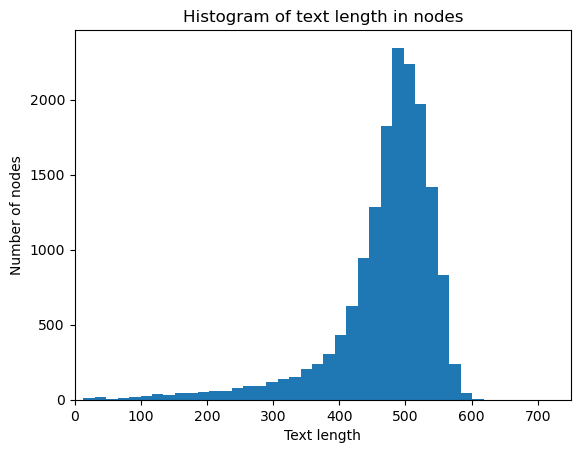

In [8]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
token_counts = []
for text in [node.text for node in nodes_vejledninger_not_token]:
    token_counts.append(len(tokenizer.tokenize(text)))

# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

#Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt
import numpy as np
text_len = token_counts
plt.hist(text_len, bins=100)
plt.title('Histogram of text length in nodes')
plt.xlabel('Text length')
plt.xlim(0, 750)
plt.ylabel('Number of nodes')
plt.show()


### Langchain

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def e5_len(text):
    return len(tokenizer.tokenize(text))

langchain_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 512,
    chunk_overlap  = 0,
    length_function = e5_len,
)

In [30]:
langchain_texts = langchain_text_splitter.create_documents([document.text for document in documents_vejledninger])

Token indices sequence length is longer than the specified maximum sequence length for this model (785 > 512). Running this sequence through the model will result in indexing errors


In [14]:
len(langchain_texts)

18388

In [31]:
langchain_texts[0].page_content

'Vejledning om beskæftigelseskravet for ret til barselsdagpenge\n\n1.Indledning\nI denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).\n\nI bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.\n\nDenne vejledning erstatter vejledning nr. 10066 af 29. december 2020 om beskæftigelseskravet for ret til barselsdagpenge.\n\nEn lønmodtager har ret til barselsdagpenge, hvis pågældende opfylder ét af de fem krav om tilknytning til arbejdsmarkedet, der er nævnt i lovens § 27, stk. 1.\n\nKravet om aktuel beskæftigelse dagen før fraværet eller på første fraværsdag samt beskæftigelse i mindst 160 timer indberettet i indkomstregistret inden for de seneste 4 afsluttede kalendermåneder forud for fraværsperioden, jf. lovens § 27, stk. 1, nr. 1, er beskrevet i pkt

In [29]:
langchain_texts[1].page_content

'Kravet om inden for den seneste måned at have afsluttet en erhvervsmæssig uddannelse af mindst 18 måneders varighed, jf. lovens § 27, stk. 1, nr. 4, er beskrevet i pkt. 2.3.\n\nKravet om at være elev i lønnet praktik i en uddannelse, der er reguleret ved eller i henhold til lov, jf. lovens § 27, stk. 1, nr. 5, er beskrevet i pkt. 2.4.\n\nKravet om at være ansat i fleksjob, jf. lovens § 27, stk. 1, nr. 6, er beskrevet i pkt. 2.5.'

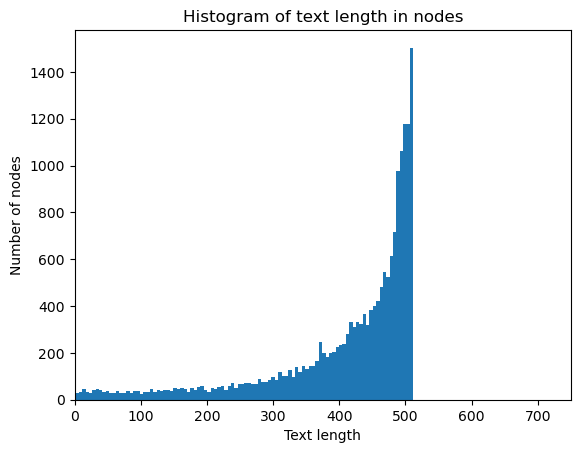

In [36]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
token_counts = []
#Iterate over .page_content of each langchain_text
for text in [str(text.page_content) for text in langchain_texts]:
    token_counts.append(len(tokenizer.tokenize(text)))

# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

#Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt
import numpy as np
text_len = token_counts
plt.hist(text_len, bins=100)
plt.title('Histogram of text length in nodes')
plt.xlabel('Text length')
plt.xlim(0, 750)
plt.ylabel('Number of nodes')
plt.show()


In [37]:
#Print first 5 examples of texts under 100 tokens

for i in range(5):
    print(f'Example {i+1} of texts under 100 tokens:')
    print([str(text.page_content) for text in langchain_texts if len(tokenizer.tokenize(str(text.page_content))) < 100][i])
    print('\n')

Example 1 of texts under 100 tokens:
Vejledning om lungesygdomme
Kapitel 7 i Vejledning om erhvervssygdomme anmeldt fra 1. januar 2005
Indhold


Example 2 of texts under 100 tokens:
2.Kronisk bronkitis/KOL (E.7)
2.1.Punkt på fortegnelsen
Sygdommen kronisk bronkitis/KOL er optaget på fortegnelsen over erhvervssygdomme (gruppe E, punkt 7).


Example 3 of texts under 100 tokens:
Sygdommen astma er optaget på fortegnelsen over erhvervssygdomme (gruppe E, punkt 8):


Example 4 of texts under 100 tokens:
4.Hvad må unge ikke arbejde med?
Unge på 13-14 år samt ældre unge, der stadig er omfattet af undervisningspligten, må ikke arbejde med noget, der kan være farligt for deres sikkerhed og sundhed.


Example 5 of texts under 100 tokens:
Arbejde med nanomaterialer
De vigtigste regler om forebyggelse af sundhedsfarlige påvirkninger ved arbejde med fremstillede nanomaterialer.
At-vejledning 9.3.1-1
November 2014 - Opdateret juli 2019




## Custom character splitter

In [49]:
from transformers import AutoTokenizer

def split_text(text, tokenizer, max_chunk_size):
    """
    Recursively splits the text into chunks that do not exceed max_chunk_size.
    Tries to find the largest possible chunk, splitting at '\n', '.', '!', and '?'.
    """
    # Tokenize and check the length
    tokens = tokenizer.tokenize(text)
    if len(tokens) <= max_chunk_size:
        return [text]

    # Delimiters to consider for splitting
    split_points = ['\n', '.', '!', '?']
    best_split = None

    # Find the best split point
    for point in split_points:
        split_index = text.rfind(point, 0, len(tokenizer.tokenize(text[:max_chunk_size])))
        if split_index != -1 and (best_split is None or split_index > best_split):
            best_split = split_index

    # If a suitable split point is found
    if best_split is not None:
        first_chunk = text[:best_split + 1]
        remaining_text = text[best_split + 1:]
        return [first_chunk] + split_text(remaining_text, tokenizer, max_chunk_size)

    # If no suitable split point is found, do a hard split at max_chunk_size
    hard_split_point = len(tokenizer.tokenize(text[:max_chunk_size]))
    first_chunk = text[:hard_split_point]
    remaining_text = text[hard_split_point:]
    return [first_chunk] + split_text(remaining_text, tokenizer, max_chunk_size)

def recursive_split(text_list, max_chunk_size):
    """
    Applies the recursive splitting to a list of strings.
    """
    tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
    all_chunks = []
    for text in text_list:
        chunks = split_text(text, tokenizer, max_chunk_size)
        all_chunks.extend(chunks)
    return all_chunks

# Example usage
text_list = ["Your long text string here..."]
chunks = recursive_split(text_list, max_chunk_size=100)  # Adjust max_chunk_size as needed
for chunk in chunks:
    print(chunk)


Your long text string here...


In [50]:
custom_split_texts = recursive_split([str(text.page_content) for text in langchain_texts], max_chunk_size=512)

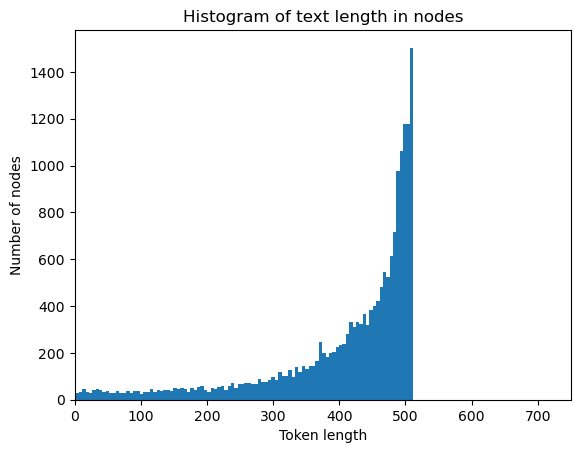

In [51]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
token_counts = []
#Iterate over .page_content of each langchain_text
for text in custom_split_texts:
    token_counts.append(len(tokenizer.tokenize(text)))

# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

#Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt
import numpy as np
text_len = token_counts
plt.hist(text_len, bins=100)
plt.title('Histogram of text length in nodes')
plt.xlabel('Token length')
plt.xlim(0, 750)
plt.ylabel('Number of nodes')
plt.show()


In [45]:
vejledninger_tekst_dict['Vejledning om lungesygdomme'][0:3000]

'Vejledning om lungesygdomme\nKapitel 7 i Vejledning om erhvervssygdomme anmeldt fra 1. januar 2005\nIndhold\n\n1.Pleurale plaques (E.3.3)\nIndledning\nDenne vejledning er skrevet af Arbejdsskadestyrelsen med henblik på at beskrive betingelserne for afgørelse i sager om erhvervssygdomme, der anmeldes fra 1. januar 2005.\nVejledningen gælder således kun for sygdomme anmeldt fra 1. januar 2005, der vurderes efterlov om arbejdsskadesikring, jf. bekendtgørelse nr. 278 af 14. marts 2013med senere ændringer.\nSygdomme anmeldt før 1. januar 2005 vurderes efterlov nr. 943 om sikring mod følger af arbejdsskade af 16. oktober 2000med senere ændringer og er ikke omfattet af denne vejledning.\nVejledningen er skrevet til alle, der har brug for at orientere sig om behandlingen af erhvervssygdomme, herunder Arbejdsskadestyrelsens sagsbehandlere, fagforeninger, advokater og forsikringsselskaber.\nVejledningen skal være en hjælp til behandling af sagerne og skal give en forståelse af kravene til samme

In [52]:
#Print 10 of the shortest texts
for i in range(10):
    print(f'Example {i+1} of texts under 100 tokens:')
    print([text for text in custom_split_texts if len(tokenizer.tokenize(text)) < 100][i])
    print('\n')

Example 1 of texts under 100 tokens:
Vejledning om lungesygdomme
Kapitel 7 i Vejledning om erhvervssygdomme anmeldt fra 1. januar 2005
Indhold


Example 2 of texts under 100 tokens:


KeyboardInterrupt: 

## Random stuff

In [19]:
from llama_index.node_parser import SimpleNodeParser

node_parser = SimpleNodeParser.from_defaults(chunk_size=512, chunk_overlap=20)
nodes = node_parser.get_nodes_from_documents(documents, show_progress=True)

Parsing nodes:   0%|          | 0/431 [00:00<?, ?it/s]

In [ ]:
from llama_index.node_parser import SentenceWindowNodeParser 

window_node_parser = SentenceWindowNodeParser(sentence_splitter,
                                              window_size=3,
                                              include_prev_next_rel=True,
                                              include_metadata=True)


window_nodes_vejledninger = window_node_parser.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

In [ ]:
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)
service_context = ServiceContext.from_defaults(text_splitter=text_splitter)